<style>
pre {
 white-space: pre-wrap !important;
}
.table-striped > tbody > tr:nth-of-type(odd) {
    background-color: #f9f9f9;
}
.table-striped > tbody > tr:nth-of-type(even) {
    background-color: white;
}
.table-striped td, .table-striped th, .table-striped tr {
    border: 1px solid black;
    border-collapse: collapse;
    margin: 1em 2em;
}
.rendered_html td, .rendered_html th {
    text-align: left;
    vertical-align: middle;
    padding: 4px;
}
</style>

# Machine Learning (advanced): the Titanic dataset

If you want to try out this notebook with a live Python kernel, use mybinder:

<a class="reference external image-reference" href="https://mybinder.org/v2/gh/vaexio/vaex/latest?filepath=docs%2Fsource%2Fexample_ml_titanic.ipynb"><img alt="https://mybinder.org/badge_logo.svg" src="https://mybinder.org/badge_logo.svg" width="150px"></a>


In the following is a more involved machine learning example, in which we will use a larger variety of method in `veax` to do data cleaning, feature engineering, pre-processing and finally to train a couple of models. To do this, we will use the well known _Titanic dataset_. Our task is to predict which passengers are more likely to have survived the disaster. 

Before we begin, thare there are two important notes to consider:
 - The following example is not to provide a competitive score for any competitions that might use the _Titanic dataset_. It's primary goal is to show how various methods provided by `vaex` and `vaex.ml` can be used to clean data, create new features, and do general data manipulations in a machine learning context. 
 - While the _Titanic dataset_ is rather small in side, all the methods and operations presented in the solution below will work on a dataset of arbitrary size, as long as it fits on the hard-drive of your machine.
 
Now, with that out of the way, let's get started!

In [1]:
import vaex
import vaex.ml

import numpy as np
import pylab as plt

## Adjusting `matplotlib` parmeters

_Intermezzo:_ we modify some of the `matplotlib` default settings, just to make the plots a bit more legible.

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Get the data

First of all we need to read in the data. Since the _Titanic dataset_ is quite well known for trying out different classification algorithms, as well as commonly used as a teaching tool for aspiring data scientists, it ships (no pun intended) together with `vaex.ml`. So let's read it in, see the description of its contents, and get a preview of the data.

In [3]:
# Load the titanic dataset
df = vaex.ml.datasets.load_titanic()

# See the description
df.info()

column,type,unit,description,expression
pclass,int64,,,
survived,bool,,,
name,str,,,
sex,str,,,
age,float64,,,
sibsp,int64,,,
parch,int64,,,
ticket,str,,,
fare,float64,,,
cabin,str,,,


### Shuffling
From the preview of the DataFrame we notice that the data is sorted alphabetically by name and by passenger class.
Thus we need to shuffle it before we split it into train and test sets.

In [4]:
# The dataset is ordered, so let's shuffle it
df = df.sample(frac=1, random_state=31)

### Shuffling for large datasets
As mentioned in [The ML introduction tutorial](tutorial_ml_intro.ipynb), shuffling large datasets in-memory is not a good idea. In case you work with a large dataset, consider shuffling while exporting:

```
df.export("shuffled", shuffle=True)
df = vaex.open("shuffled.hdf5)
df_train, df_test = df.ml.train_test_split(test_size=0.2)
```

### Split into train and test
Once the data is shuffled, let's split it into train and test sets. The test set will comprise 20% of the data. Note that we do not shuffle the data for you, since vaex cannot assume your data fits into memory, you are responsible for either writing it in shuffled order on disk, or shuffle it in memory (the previous step).

In [5]:
# Train and test split, no shuffling occurs
df_train, df_test = df.ml.train_test_split(test_size=0.2, verbose=False)

### Sanity checks

Before we move on to process the data, let's verify that our train and test sets are "similar" enough. We will not be very rigorous here, but just look at basic statistics of some of the key features.

For starters, let's check that the fraction of survivals is similar between the train and test sets.

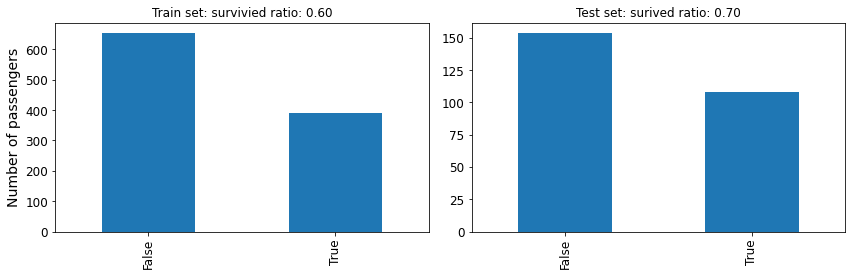

In [6]:
# Inspect the target variable
train_survived_value_counts = df_train.survived.value_counts()
test_survived_value_counts = df_test.survived.value_counts()


plt.figure(figsize=(12, 4))

plt.subplot(121)
train_survived_value_counts.plot.bar()
train_sex_ratio = train_survived_value_counts[True]/train_survived_value_counts[False]
plt.title(f'Train set: survivied ratio: {train_sex_ratio:.2f}')
plt.ylabel('Number of passengers')

plt.subplot(122)
test_survived_value_counts.plot.bar()
test_sex_ratio = test_survived_value_counts[True]/test_survived_value_counts[False]
plt.title(f'Test set: surived ratio: {test_sex_ratio:.2f}')


plt.tight_layout()
plt.show()

Next up, let's check whether the ratio of male to female passengers is not too dissimilar between the two sets.

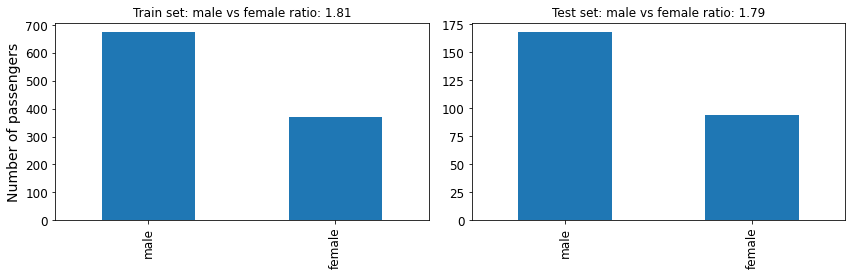

In [7]:
# Check the sex balance
train_sex_value_counts = df_train.sex.value_counts()
test_sex_value_counts = df_test.sex.value_counts()

plt.figure(figsize=(12, 4))

plt.subplot(121)
train_sex_value_counts.plot.bar()
train_sex_ratio = train_sex_value_counts['male']/train_sex_value_counts['female']
plt.title(f'Train set: male vs female ratio: {train_sex_ratio:.2f}')
plt.ylabel('Number of passengers')

plt.subplot(122)
test_sex_value_counts.plot.bar()
test_sex_ratio = test_sex_value_counts['male']/test_sex_value_counts['female']
plt.title(f'Test set: male vs female ratio: {test_sex_ratio:.2f}')


plt.tight_layout()
plt.show()

Finally, lets check that the relative number of passenger per class is similar between the train and test sets.

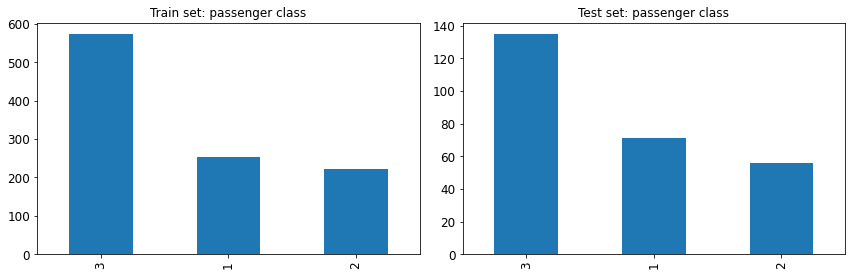

In [8]:
# Check the class balance
train_pclass_value_counts = df_train.pclass.value_counts()
test_pclass_value_counts = df_test.pclass.value_counts()

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.title('Train set: passenger class')
train_pclass_value_counts.plot.bar()

plt.subplot(122)
plt.title('Test set: passenger class')
test_pclass_value_counts.plot.bar()

plt.tight_layout()
plt.show()

From the above diagnostics, we are satisfied that, at least in these few categories, the train and test are similar enough, and we can move forward.

## Feature engineering

In this section we will use `vaex` to create meaningful features that will be used to train a classification model. To start with, let's get a high level overview of the training data.

In [9]:
df_train.describe()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
dtype,int64,bool,str,str,float64,int64,int64,str,float64,str,str,str,float64,str
count,1047,1047,1047,1047,841,1047,1047,1047,1046,233,1046,380,102,592
NA,0,0,0,0,206,0,0,0,1,814,1,667,945,455
mean,2.3075453677172875,0.3744030563514804,--,--,29.565299286563608,0.5100286532951289,0.3982808022922636,--,32.926091013384294,--,--,--,159.6764705882353,--
std,0.833269,0.483968,--,--,14.162,1.07131,0.890852,--,50.6783,--,--,--,96.2208,--
min,1,False,--,--,0.1667,0,0,--,0,--,--,--,1,--
max,3,True,--,--,80,8,9,--,512.329,--,--,--,327,--


### Imputing

We notice that there are 3 columns that have missing data, so our first task will be to impute the missing values with suitable substitutes. This is our strategy:

- age: impute with the median age value
- fare: impute with the mean fare of the 5 most common values.
- cabin: impute with "M" for "Missing"
- Embarked: Impute with with the most common value.

In [10]:
# Handle missing values

# Age - just do the mean of the training set for now
median_age = df_train.percentile_approx(expression='age', percentage=50.0)
df_train['age'] = df_train.age.fillna(value=median_age)

# Fare: the mean of the 5 most common ticket prices.
fill_fares = df_train.fare.value_counts(dropna=True)
fill_fare = fill_fares.iloc[:5].index.values.mean()
df_train['fare'] = df_train.fare.fillna(value=fill_fare)

# Cabing: this is a string column so let's mark it as "M" for "Missing"
df_train['cabin'] = df_train.cabin.fillna(value='M')

# Embarked: Similar as for Cabin, let's mark the missing values with "U" for unknown
fill_embarked = df_train.embarked.value_counts(dropna=True).index[0]
df_train['embarked'] = df_train.embarked.fillna(value=fill_embarked)

### String processing

Next up, let's engineer some new, more meaningful features out of the "raw" data that is present in the dataset. 
Starting with the name of the passengers, we are going to extract the titles, as well as we are going to count the number of words a name contains. These features can be a loose proxy to the age and status of the passengers.

In [11]:
# Engineer features from the names

# Titles
df_train['name_title'] = df_train['name'].str.replace('.* ([A-Z][a-z]+)\..*', "\\1", regex=True)
display(df_train['name_title'])

# Number of words in the name
df_train['name_num_words'] = df_train['name'].str.count("[ ]+", regex=True) + 1
display(df_train['name_num_words'])

Expression = name_title
Length: 1,047 dtype: str (column)
---------------------------------
   0      Mr
   1      Mr
   2     Mrs
   3    Miss
   4      Mr
    ...     
1042  Master
1043     Mrs
1044  Master
1045      Mr
1046      Mr

Expression = name_num_words
Length: 1,047 dtype: int64 (column)
-----------------------------------
   0  3
   1  4
   2  5
   3  4
   4  4
  ...  
1042  4
1043  6
1044  4
1045  4
1046  3

From the cabin colum, we will engineer 3 features:
 - "deck": extacting the deck on which the cabin is located, which is encoded in each cabin value;
 - "multi_cabin: a boolean feature indicating whether a passenger is allocated more than one cabin
 - "has_cabin": since there were plenty of values in the original cabin column that had missing values, we are just going to build a feature which tells us whether a passenger had an assigned cabin or not.

In [12]:
#  Extract the deck
df_train['deck'] = df_train.cabin.str.slice(start=0, stop=1)
display(df_train['deck'])

# Passengers under which name have several rooms booked, these are all for 1st class passengers
df_train['multi_cabin'] = ((df_train.cabin.str.count(pat='[A-Z]', regex=True) > 1) &\
                           ~(df_train.deck == 'F')).astype('int')
display(df_train['multi_cabin'])

# Out of these, cabin has the most missing values, so let's create a feature tracking if a passenger had a cabin
df_train['has_cabin'] = df_train.cabin.notna().astype('int')
display(df_train['has_cabin'])

Expression = deck
Length: 1,047 dtype: str (column)
---------------------------------
   0  M
   1  B
   2  M
   3  M
   4  M
  ...  
1042  M
1043  M
1044  M
1045  B
1046  M

Expression = multi_cabin
Length: 1,047 dtype: int64 (column)
-----------------------------------
   0  0
   1  0
   2  0
   3  0
   4  0
  ...  
1042  0
1043  0
1044  0
1045  1
1046  0

Expression = has_cabin
Length: 1,047 dtype: int64 (column)
-----------------------------------
   0  1
   1  1
   2  1
   3  1
   4  1
  ...  
1042  1
1043  1
1044  1
1045  1
1046  1

### More features

There are two features that give an indication whether a passenger is travelling alone, or with a famly. 
These are the "sibsp" and "parch" columns that tell us the number of siblinds or spouses and the number of parents or children each passenger has on-board respectively. We are going to use this information to build two columns:
 - "family_size" the size of the family of each passenger;
 - "is_alone" an additional boolean feature which indicates whether a passenger is traveling without their family. 

In [13]:
# Size of family that are on board: passenger + number of siblings, spouses, parents, children. 
df_train['family_size'] = (df_train.sibsp + df_train.parch + 1)
display(df_train['family_size'])

# Whether or not a passenger is alone
df_train['is_alone'] = (df_train.family_size == 0).astype('int')
display(df_train['is_alone'])

Expression = family_size
Length: 1,047 dtype: int64 (column)
-----------------------------------
   0  1
   1  1
   2  3
   3  4
   4  1
  ...  
1042  8
1043  2
1044  3
1045  2
1046  1

Expression = is_alone
Length: 1,047 dtype: int64 (column)
-----------------------------------
   0  0
   1  0
   2  0
   3  0
   4  0
  ...  
1042  0
1043  0
1044  0
1045  0
1046  0

Finally, let's create two new features:
 - age $\times$  class
 - fare per family member, i.e. fare $/$ family_size

In [14]:
# Create new features
df_train['age_times_class'] = df_train.age * df_train.pclass

# fare per person in the family
df_train['fare_per_family_member'] = df_train.fare / df_train.family_size

## Modeling (part 1): gradient boosted trees

Since this dataset contains a lot of categorical features, we will start with a tree based model. This we will gear the following feature pre-processing towards the use of tree-based models.

### Feature pre-processing for boosted tree models

The features "sex", "embarked", and "deck" can be simply label encoded. The feature "name_tite" contains certain a larger degree of cardinality, relative to the size of the training set, and in this case we will use the Frequency Encoder.

In [15]:
label_encoder = vaex.ml.LabelEncoder(features=['sex', 'embarked', 'deck'], allow_unseen=True)
df_train = label_encoder.fit_transform(df_train)

# While doing a transform, previously unseen values will be encoded as "zero".
frequency_encoder = vaex.ml.FrequencyEncoder(features=['name_title'], unseen='zero')
df_train = frequency_encoder.fit_transform(df_train)
df_train

INFO:MainThread:numexpr.utils:NumExpr defaulting to 4 threads.


#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,name_title,name_num_words,deck,multi_cabin,has_cabin,family_size,is_alone,age_times_class,fare_per_family_member,label_encoded_sex,label_encoded_embarked,label_encoded_deck,frequency_encoded_name_title
0,3,False,"Stoytcheff, Mr. Ilia",male,19.0,0,0,349205,7.8958,M,S,None,nan,None,Mr,3,M,0,1,1,0,57.0,7.8958,0,0,0,0.5787965616045845
1,1,False,"Payne, Mr. Vivian Ponsonby",male,23.0,0,0,12749,93.5,B24,S,None,nan,"Montreal, PQ",Mr,4,B,0,1,1,0,23.0,93.5,0,0,1,0.5787965616045845
2,3,True,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.25,M,S,A,nan,"East Providence, RI",Mrs,5,M,0,1,3,0,105.0,6.75,1,0,0,0.1451766953199618
3,2,True,"Hocking, Miss. Ellen ""Nellie""",female,20.0,2,1,29105,23.0,M,S,4,nan,"Cornwall / Akron, OH",Miss,4,M,0,1,4,0,40.0,5.75,1,0,0,0.20152817574021012
4,3,False,"Nilsson, Mr. August Ferdinand",male,21.0,0,0,350410,7.8542,M,S,None,nan,None,Mr,4,M,0,1,1,0,63.0,7.8542,0,0,0,0.5787965616045845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,042",3,False,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,M,S,None,nan,"Wiltshire, England Niagara Falls, NY",Master,4,M,0,1,8,0,3.0,5.8625,0,0,0,0.045845272206303724
"1,043",3,False,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.475,M,S,None,nan,"Sweden Akeley, MN",Mrs,6,M,0,1,2,0,120.0,4.7375,1,0,0,0.1451766953199618
"1,044",3,True,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,M,S,15,nan,None,Master,4,M,0,1,3,0,12.0,3.7111,0,0,0,0.045845272206303724
"1,045",1,False,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,None,nan,"Montreal, PQ",Mr,4,B,1,1,2,0,24.0,123.7604,0,2,1,0.5787965616045845


Once all the categorical data is encoded, we can select the features we are going to use for training the model.

In [16]:
# features to use for the trainin of the boosting model
encoded_features = df_train.get_column_names(regex='^freque|^label')
features = encoded_features + ['multi_cabin', 'name_num_words', 
                               'has_cabin', 'is_alone', 
                               'family_size', 'age_times_class',
                               'fare_per_family_member',
                               'age', 'fare']

# Preview the feature matrix
df_train[features].head(5)

#,label_encoded_sex,label_encoded_embarked,label_encoded_deck,frequency_encoded_name_title,multi_cabin,name_num_words,has_cabin,is_alone,family_size,age_times_class,fare_per_family_member,age,fare
0,0,0,0,0.578797,0,3,1,0,1,57,7.8958,19,7.8958
1,0,0,1,0.578797,0,4,1,0,1,23,93.5,23,93.5
2,1,0,0,0.145177,0,5,1,0,3,105,6.75,35,20.25
3,1,0,0,0.201528,0,4,1,0,4,40,5.75,20,23
4,0,0,0,0.578797,0,4,1,0,1,63,7.8542,21,7.8542


### Estimator: [xgboost](https://xgboost.readthedocs.io/en/latest/)

Now let's feed this data into an a tree based estimator. In this example we will use [xgboost](https://xgboost.readthedocs.io/en/latest/). In principle, any algorithm that follows the [scikit-learn](https://scikit-learn.org/stable/) API convention, i.e. it contains the `.fit`, `.predict` methods is compatable with `vaex`. However, the data will be materialized, i.e. will be read into memory before it is passed on to the estimators. We are hard at work trying to make at least some of the estimators from [scikit-learn](https://scikit-learn.org/stable/) run out-of-core!


In [17]:
import xgboost
import vaex.ml.sklearn

# Instantiate the xgboost model normally, using the scikit-learn API
xgb_model = xgboost.sklearn.XGBClassifier(max_depth=11,
                                          learning_rate=0.1, 
                                          n_estimators=500, 
                                          subsample=0.75, 
                                          colsample_bylevel=1, 
                                          colsample_bytree=1,
                                          scale_pos_weight=1.5,
                                          reg_lambda=1.5, 
                                          reg_alpha=5, 
                                          n_jobs=-1,
                                          random_state=42,
                                          verbosity=0)

# Make it work with vaex (for the automagic pipeline and lazy predictions)
vaex_xgb_model = vaex.ml.sklearn.Predictor(features=features,
                                           target='survived',
                                           model=xgb_model, 
                                           prediction_name='prediction_xgb')
# Train the model
vaex_xgb_model.fit(df_train)
# Get the prediction of the model on the training data
df_train = vaex_xgb_model.transform(df_train)

# Preview the resulting train dataframe that contans the predictions
df_train

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,name_title,name_num_words,deck,multi_cabin,has_cabin,family_size,is_alone,age_times_class,fare_per_family_member,label_encoded_sex,label_encoded_embarked,label_encoded_deck,frequency_encoded_name_title,prediction_xgb
0,3,False,"Stoytcheff, Mr. Ilia",male,19.0,0,0,349205,7.8958,M,S,None,nan,None,Mr,3,M,0,1,1,0,57.0,7.8958,0,0,0,0.5787965616045845,False
1,1,False,"Payne, Mr. Vivian Ponsonby",male,23.0,0,0,12749,93.5,B24,S,None,nan,"Montreal, PQ",Mr,4,B,0,1,1,0,23.0,93.5,0,0,1,0.5787965616045845,False
2,3,True,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.25,M,S,A,nan,"East Providence, RI",Mrs,5,M,0,1,3,0,105.0,6.75,1,0,0,0.1451766953199618,True
3,2,True,"Hocking, Miss. Ellen ""Nellie""",female,20.0,2,1,29105,23.0,M,S,4,nan,"Cornwall / Akron, OH",Miss,4,M,0,1,4,0,40.0,5.75,1,0,0,0.20152817574021012,True
4,3,False,"Nilsson, Mr. August Ferdinand",male,21.0,0,0,350410,7.8542,M,S,None,nan,None,Mr,4,M,0,1,1,0,63.0,7.8542,0,0,0,0.5787965616045845,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,042",3,False,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,M,S,None,nan,"Wiltshire, England Niagara Falls, NY",Master,4,M,0,1,8,0,3.0,5.8625,0,0,0,0.045845272206303724,False
"1,043",3,False,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",female,40.0,1,0,7546,9.475,M,S,None,nan,"Sweden Akeley, MN",Mrs,6,M,0,1,2,0,120.0,4.7375,1,0,0,0.1451766953199618,False
"1,044",3,True,"Johnson, Master. Harold Theodor",male,4.0,1,1,347742,11.1333,M,S,15,nan,None,Master,4,M,0,1,3,0,12.0,3.7111,0,0,0,0.045845272206303724,True
"1,045",1,False,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,None,nan,"Montreal, PQ",Mr,4,B,1,1,2,0,24.0,123.7604,0,2,1,0.5787965616045845,False


Notice that in the above cell block, we call `.transform` on the `vaex_xgb_model` object. This adds the "prediction_xgb" column as _virtual column_ in the output dataframe. This can be quite convenient when calculating various metrics and making diagnosic plots. Of course, one can call a `.predict` on the `vaex_xgb_model` object, which returns an in-memory `numpy` array object housing the predictions.

### Performance on training set

Anyway, let's see what the performance is of the model on the training set. First let's create a convenience function that will help us get multiple metrics at once.

In [18]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
def binary_metrics(y_true, y_pred):
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    roc = roc_auc_score(y_true=y_true, y_score=y_pred)
    print(f'Accuracy: {acc:.3f}')
    print(f'f1 score: {f1:.3f}')
    print(f'roc-auc: {roc:.3f}')

Now let's check the performance of the model on the training set.

In [19]:
print('Metrics for the training set:')
binary_metrics(y_true=df_train.survived.values, y_pred=df_train.prediction_xgb.values)

Metrics for the training set:
Accuracy: 0.924
f1 score: 0.896
roc-auc: 0.914


### Automatic pipelines

Now, let's inspect the performance of the model on the test set. You probably noticed that, unlike when using other libraries, we did not bother to create a pipeline while doing all the cleaning, inputing, feature engineering and categorial encoding. Well, we did not _explicitly_ create a pipeline. In fact `veax` keeps track of all the changes one applies to a DataFrame in something called a state. A state is the place which contains all the informations regarding, for instance, the virtual columns we've created, which includes the newly engineered features, the categorically encoded columns, and even the model prediction! So all we need to do, is to extract the state from the training DataFrame, and apply it to the test DataFrame.

In [20]:
# state transfer to the test set
state = df_train.state_get()
df_test.state_set(state)

# Preview of the "transformed" test set
df_test.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,name_title,name_num_words,deck,multi_cabin,has_cabin,family_size,is_alone,age_times_class,fare_per_family_member,label_encoded_sex,label_encoded_embarked,label_encoded_deck,frequency_encoded_name_title,prediction_xgb
0,3,False,"O'Connor, Mr. Patrick",male,28.032,0,0,366713,7.75,M,Q,None,nan,None,Mr,3,M,0,1,1,0,84.096,7.75,0,1,0,0.578797,False
1,3,False,"Canavan, Mr. Patrick",male,21,0,0,364858,7.75,M,Q,None,nan,"Ireland Philadelphia, PA",Mr,3,M,0,1,1,0,63,7.75,0,1,0,0.578797,False
2,1,False,"Ovies y Rodriguez, Mr. Servando",male,28.5,0,0,PC 17562,27.7208,D43,C,None,189,"?Havana, Cuba",Mr,5,D,0,1,1,0,28.5,27.7208,0,2,4,0.578797,True
3,3,False,"Windelov, Mr. Einar",male,21,0,0,SOTON/OQ 3101317,7.25,M,S,None,nan,None,Mr,3,M,0,1,1,0,63,7.25,0,0,0,0.578797,False
4,2,True,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25,0,1,230433,26,M,S,12,nan,"Deer Lodge, MT",Mrs,6,M,0,1,2,0,50,13,1,0,0,0.145177,True


Notice that once we apply the state from the train to the test set, the test DataFrame contains all the features we created or modified in the training data, and even the predictions of the xgboost model!

The state is a simple Python dictionary, which can be easily stored as JSON to disk, which makes it very easy to deploy.

### Performance on test set

Now it is trivial to check the model performance on the test set:

In [21]:
print('Metrics for the test set:')
binary_metrics(y_true=df_test.survived.values, y_pred=df_test.prediction_xgb.values)

Metrics for the test set:
Accuracy: 0.798
f1 score: 0.744
roc-auc: 0.785


### Feature importance
Let's now look at the feature importance of the `xgboost` model.

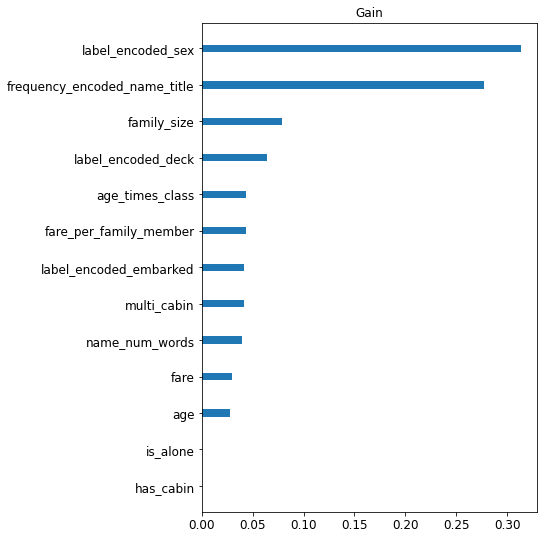

In [22]:
plt.figure(figsize=(6, 9))

ind = np.argsort(xgb_model.feature_importances_)[::-1]
features_sorted = np.array(features)[ind]
importances_sorted = xgb_model.feature_importances_[ind]

plt.barh(y=range(len(features)), width=importances_sorted, height=0.2)
plt.title('Gain')
plt.yticks(ticks=range(len(features)), labels=features_sorted)
plt.gca().invert_yaxis()
plt.show()

## Modeling (part 2): Linear models & Ensembles

Given the randomness of the _Titanic dataset_ , we can be satisfied with the performance of `xgboost` model above. Still, it is always usefull to try a variety of models and approaches, especially since `vaex` makes makes this process rather simple. 

In the following part we will use a couple of linear models as our predictors, this time straight from `scikit-learn`. This requires us to pre-process the data in a slightly different way.

### Feature pre-processing for linear models

When using linear models, the safest option is to encode categorical variables with the one-hot encoding scheme, especially if they have low cardinality. We will do this for the "family_size" and "deck" features. Note that the "sex" feature is already encoded since it has only unique values options. 

The "name_title" feature is a bit more tricky. Since in its original form it has some values that only appear a couple of times, we will do a trick: we will one-hot encode the frequency encoded values. This will reduce cardinality of the feature, while also preserving the most important, i.e. most common values.

Regarding the "age" and "fare", to add some variance in the model, we will not convert them to categorical as before, but simply remove their mean and standard-deviations (standard-scaling). We will do the same to the "fare_per_family_member" feature.


Finally, we will drop out any other features.

In [23]:
# One-hot encode categorical features
one_hot = vaex.ml.OneHotEncoder(features=['deck', 'family_size', 'name_title'])
df_train = one_hot.fit_transform(df_train)

In [24]:
# Standard scale numerical features
standard_scaler = vaex.ml.StandardScaler(features=['age', 'fare', 'fare_per_family_member'])
df_train = standard_scaler.fit_transform(df_train)

In [25]:
# Get the features for training a linear model
features_linear = df_train.get_column_names(regex='^deck_|^family_size_|^frequency_encoded_name_title_')
features_linear += df_train.get_column_names(regex='^standard_scaled_')
features_linear += ['label_encoded_sex']
features_linear

['deck_A',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 'deck_F',
 'deck_G',
 'deck_M',
 'family_size_1',
 'family_size_2',
 'family_size_3',
 'family_size_4',
 'family_size_5',
 'family_size_6',
 'family_size_7',
 'family_size_8',
 'family_size_11',
 'standard_scaled_age',
 'standard_scaled_fare',
 'standard_scaled_fare_per_family_member',
 'label_encoded_sex']

### Estimators: `SVC` and `LogisticRegression`

In [26]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [27]:
# The Support Vector Classifier
vaex_svc = vaex.ml.sklearn.Predictor(features=features_linear, 
                                     target='survived',
                                     model=SVC(max_iter=1000, random_state=42),
                                     prediction_name='prediction_svc')

# Logistic Regression
vaex_logistic = vaex.ml.sklearn.Predictor(features=features_linear, 
                                          target='survived',
                                          model=LogisticRegression(max_iter=1000, random_state=42),
                                          prediction_name='prediction_lr')

# Train the new models and apply the transformation to the train dataframe
for model in [vaex_svc, vaex_logistic]:
    model.fit(df_train)
    df_train = model.transform(df_train)
    
# Preview of the train DataFrame
df_train.head(5)

/Users/jovan/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,name_title,name_num_words,deck,multi_cabin,has_cabin,family_size,is_alone,age_times_class,fare_per_family_member,label_encoded_sex,label_encoded_embarked,label_encoded_deck,frequency_encoded_name_title,prediction_xgb,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_M,family_size_1,family_size_2,family_size_3,family_size_4,family_size_5,family_size_6,family_size_7,family_size_8,family_size_11,name_title_Capt,name_title_Col,name_title_Countess,name_title_Don,name_title_Dona,name_title_Dr,name_title_Jonkheer,name_title_Lady,name_title_Major,name_title_Master,name_title_Miss,name_title_Mlle,name_title_Mme,name_title_Mr,name_title_Mrs,name_title_Ms,name_title_Rev,standard_scaled_age,standard_scaled_fare,standard_scaled_fare_per_family_member,prediction_svc,prediction_lr
0,3,False,"Stoytcheff, Mr. Ilia",male,19,0,0,349205,7.8958,M,S,None,nan,None,Mr,3,M,0,1,1,0,57,7.8958,0,0,0,0.578797,False,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.807704,-0.493719,-0.342804,False,False
1,1,False,"Payne, Mr. Vivian Ponsonby",male,23,0,0,12749,93.5,B24,S,None,nan,"Montreal, PQ",Mr,4,B,0,1,1,0,23,93.5,0,0,1,0.578797,False,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.492921,1.19613,1.99718,False,True
2,3,True,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35,1,1,C.A. 2673,20.25,M,S,A,nan,"East Providence, RI",Mrs,5,M,0,1,3,0,105,6.75,1,0,0,0.145177,True,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.45143,-0.249845,-0.374124,True,True
3,2,True,"Hocking, Miss. Ellen ""Nellie""",female,20,2,1,29105,23,M,S,4,nan,"Cornwall / Akron, OH",Miss,4,M,0,1,4,0,40,5.75,1,0,0,0.201528,True,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-0.729008,-0.195559,-0.401459,True,True
4,3,False,"Nilsson, Mr. August Ferdinand",male,21,0,0,350410,7.8542,M,S,None,nan,None,Mr,4,M,0,1,1,0,63,7.8542,0,0,0,0.578797,False,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.650312,-0.494541,-0.343941,False,False


### Ensemble

Just as before, the predictions from the `SVC` and the `LogisticRegression` classifiers are added as virtual columns in the training dataset. This is quite powerful, since now we can easily use them to create an ensemble! For example, let's do a weighted mean.

In [28]:
# Weighed mean of the classes
prediction_final = (df_train.prediction_xgb.astype('int') * 0.3 + 
                    df_train.prediction_svc.astype('int') * 0.5 + 
                    df_train.prediction_xgb.astype('int') * 0.2)
# Get the predicted class
prediction_final = (prediction_final >= 0.5)
# Add the expression to the train DataFrame
df_train['prediction_final'] = prediction_final

# Preview
df_train[df_train.get_column_names(regex='^predict')]

#,prediction_xgb,prediction_svc,prediction_lr,prediction_final
0,False,False,False,False
1,False,False,True,False
2,True,True,True,True
3,True,True,True,True
4,False,False,False,False
...,...,...,...,...
"1,042",False,False,False,False
"1,043",False,True,True,True
"1,044",True,True,False,True
"1,045",False,True,True,True


### Performance (part 2)

Applying the ensembler to the test set is just as easy as before. We just need to get the new state of the training DataFrame, and transfer it to the test DataFrame.

In [29]:
# State transfer
state_new = df_train.state_get()
df_test.state_set(state_new)

# Preview
df_test.head(5)

#,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest,name_title,name_num_words,deck,multi_cabin,has_cabin,family_size,is_alone,age_times_class,fare_per_family_member,label_encoded_sex,label_encoded_embarked,label_encoded_deck,frequency_encoded_name_title,prediction_xgb,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_M,family_size_1,family_size_2,family_size_3,family_size_4,family_size_5,family_size_6,family_size_7,family_size_8,family_size_11,name_title_Capt,name_title_Col,name_title_Countess,name_title_Don,name_title_Dona,name_title_Dr,name_title_Jonkheer,name_title_Lady,name_title_Major,name_title_Master,name_title_Miss,name_title_Mlle,name_title_Mme,name_title_Mr,name_title_Mrs,name_title_Ms,name_title_Rev,standard_scaled_age,standard_scaled_fare,standard_scaled_fare_per_family_member,prediction_svc,prediction_lr,prediction_final
0,3,False,"O'Connor, Mr. Patrick",male,28.032,0,0,366713,7.75,M,Q,None,nan,None,Mr,3,M,0,1,1,0,84.096,7.75,0,1,0,0.578797,False,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.096924,-0.496597,-0.346789,False,False,False
1,3,False,"Canavan, Mr. Patrick",male,21,0,0,364858,7.75,M,Q,None,nan,"Ireland Philadelphia, PA",Mr,3,M,0,1,1,0,63,7.75,0,1,0,0.578797,False,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.650312,-0.496597,-0.346789,False,False,False
2,1,False,"Ovies y Rodriguez, Mr. Servando",male,28.5,0,0,PC 17562,27.7208,D43,C,None,189,"?Havana, Cuba",Mr,5,D,0,1,1,0,28.5,27.7208,0,2,4,0.578797,True,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.0600935,-0.102369,0.19911,False,False,True
3,3,False,"Windelov, Mr. Einar",male,21,0,0,SOTON/OQ 3101317,7.25,M,S,None,nan,None,Mr,3,M,0,1,1,0,63,7.25,0,0,0,0.578797,False,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-0.650312,-0.506468,-0.360456,False,False,False
4,2,True,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25,0,1,230433,26,M,S,12,nan,"Deer Lodge, MT",Mrs,6,M,0,1,2,0,50,13,1,0,0,0.145177,True,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.335529,-0.136338,-0.203281,True,True,True


Finally, let's check the performance of all the individual models as well as on the ensembler, on the test set.

In [30]:
pred_columns = df_train.get_column_names(regex='^prediction_')
for i in pred_columns:
    print(i)
    binary_metrics(y_true=df_test.survived.values, y_pred=df_test[i].values)
    print(' ')

prediction_xgb
Accuracy: 0.798
f1 score: 0.744
roc-auc: 0.785
 
prediction_svc
Accuracy: 0.802
f1 score: 0.743
roc-auc: 0.786
 
prediction_lr
Accuracy: 0.779
f1 score: 0.713
roc-auc: 0.762
 
prediction_final
Accuracy: 0.821
f1 score: 0.785
roc-auc: 0.817
 


We see that our ensembler is doing a better job than any idividual model, as expected.

Thanks you for going over this example. Feel free to copy, modify, and in general play around with this notebook.